In [1]:
import torch
import torchvision
from torch import nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn import init

from settings import EPOCHS
from unet import UNET
from Discriminator import Discriminator
import torchvision.transforms as transforms
from torch.nn import BCELoss, L1Loss, MSELoss
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from torch.optim import lr_scheduler


def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)


def get_scheduler(optimizer):
    
    def lambda_rule(epoch):
        lr_l = 1.0 - max(0, epoch + 1 - EPOCHS) / float(EPOCHS + 1)
        return lr_l
    
    return lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)

def update_learning_rate(scheduler, optimizer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print('learning rate = %.7f' % lr)

def trainPix2Pix(model, data, totalEpochs=EPOCHS, genLr=0.0001, descLr=0.00005):
    genOptimizer = Adam( list(model.gen.parameters()), lr=0.0001)
    discOptimizer = Adam( list(model.disc.parameters()), lr=0.00005)
    
    net_g_scheduler = get_scheduler(genOptimizer)
    net_d_scheduler = get_scheduler(discOptimizer)

    
    criterion = MSELoss().cuda()
    criterionL1 = L1Loss().cuda()

    model.gen.train()
    model.disc.train()
    for epoch in range(totalEpochs):
        print("Epoch " + str(epoch))
        for minibatch, (color_and_gray, gray_three_channel) in enumerate(data):
            train_step(model, color_and_gray.cuda(), gray_three_channel.cuda(), criterion, genOptimizer, discOptimizer, criterionL1)
        
        update_learning_rate(net_g_scheduler, genOptimizer)
        update_learning_rate(net_d_scheduler, discOptimizer)

# assumes minibatch is only colord images.
def train_step(model, color, black_white, criterion, gen_optimizer, disc_optimizer, criterion_l1):    
    # generate images
    generated = model.generate(black_white)
    
    disc_optimizer.zero_grad()
    
    input_output = torch.cat((black_white, generated), 1)
    input_target = torch.cat((black_white, color), 1)
    
    # train with generated   
    pred_generated = model.discriminate(input_output.data)
    generated_labels = torch.tensor(0).expand_as(pred_generated).cuda()
    loss_false = criterion(pred_generated, generated_labels.float())
    
    # train with target
    pred_targets = model.discriminate(input_target)
    targets_labels = torch.tensor(1).expand_as(pred_targets).cuda()
    loss_true = criterion(pred_targets, targets_labels.float())
    
    print("Loss false: {} Loss true {}: ".format(loss_false, loss_true))
    loss_discriminator = (loss_false + loss_true) / 2
    loss_discriminator.backward()
    disc_optimizer.step()

    
    gen_optimizer.zero_grad()
    pred_output =  model.discriminate(input_output) 

    loss_gen = criterion(pred_output, targets_labels.float())
    # G(A) = B
    loss_ab = criterion_l1(black_white, color) * 0.9 # weight, L1 term 

    loss_gen = loss_gen + loss_ab
    
    loss_gen.backward()
    gen_optimizer.step()




class pix2pix(nn.Module):

    def __init__(self):
        super(pix2pix, self).__init__()
        numclasses = 3 #RGB
        numchannels = 64
        self.gen = UNET(numclasses, numchannels)
        self.disc = Discriminator()
#         self.criterion = CrossEntropyLoss()
        self.writer = SummaryWriter('runs/pix2pix')

    def log_image(self, images):
        # write to tensorboard
        img_grid = torchvision.utils.make_grid(images)
        self.writer.add_image('four_fashion_mnist_images', img_grid)

    def log_metrics(self, epoch, loss):
        self.writer.add_scalar('training loss', loss, epoch)
        self.trainData.append(loss)

    def generate(self, greyscale):
        return self.gen(greyscale)
        #Need to add dropout

    def discriminate(self, img):
        #(images, features, height, width)
        # Return average - 1 value for all images
        ret = self.disc(img)
        #ret = torch.mean(ret, axis=2)
        #ret = torch.mean(ret, axis=2)
        return ret






In [2]:
model = pix2pix().cuda()

In [19]:
def TenToPic(image):
    s = image.size()
    ret = torch.zeros(s[1], s[2], s[0])
    for i in range(s[0]):
        ret[:, :, i] = image[i, :,:]
    return ret.detach().numpy().astype(float)


# In[11]:


from utils import get_datasets
train_dataset, test_dataset = get_datasets()
ex = None
for i in train_dataset:
    ex = i
    break

In [30]:
ex = None
for idx, i in enumerate(train_dataset):
    ex = i
    if idx > 10: 
        break

pix2pix(
  (gen): UNET(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool4): MaxPool2d(kernel_size=2, stride=2, paddin

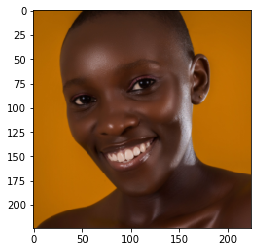

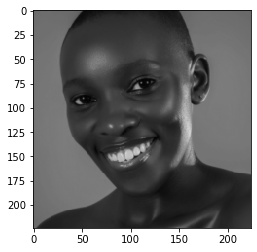

In [4]:
# out = model.generate(ex[1])
# plt.imshow(TenToPic(out[0,:,:,:]))
# plt.figure()
# plt.imshow(out.detach().numpy()[0,0,:,:])
plt.figure()
plt.imshow(TenToPic(ex[0][0,:,:,:]))
plt.figure()
plt.imshow(TenToPic(ex[1][0,:,:,:]))

model.cuda()

pix2pix(
  (gen): UNET(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool4): MaxPool2d(kernel_size=2, stride=2, paddin

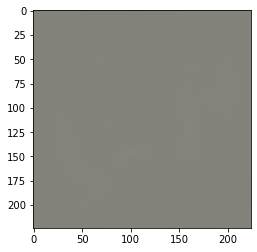

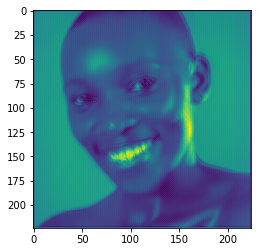

In [5]:
cpuModel = model.cpu()
out = model.generate(ex[1])
plt.imshow(TenToPic(out[0,:,:,:]))
plt.figure()
plt.imshow(out.detach().numpy()[0,0,:,:])
model.cuda()

In [6]:
trainPix2Pix(model, train_dataset, totalEpochs=100)

Epoch 0
Loss false: 0.14075815677642822 Loss true 0.9164661169052124: 
Loss false: 0.7851959466934204 Loss true 1.1608736515045166: 
Loss false: 0.22171121835708618 Loss true 0.5211920738220215: 
Loss false: 0.2576886713504791 Loss true 0.49840837717056274: 
Loss false: 0.4572490453720093 Loss true 0.5557599663734436: 
Loss false: 0.43240946531295776 Loss true 0.3782268166542053: 
Loss false: 0.35567617416381836 Loss true 0.2138621211051941: 
Loss false: 0.39497634768486023 Loss true 0.1900184452533722: 
learning rate = 0.0001000
learning rate = 0.0000500
Epoch 1
Loss false: 0.4598826467990875 Loss true 0.21962127089500427: 
Loss false: 0.44931599497795105 Loss true 0.24675655364990234: 
Loss false: 0.3865448236465454 Loss true 0.18899263441562653: 
Loss false: 0.3142603635787964 Loss true 0.18420910835266113: 
Loss false: 0.27267375588417053 Loss true 0.18218062818050385: 
Loss false: 0.26610809564590454 Loss true 0.21677303314208984: 
Loss false: 0.2486749291419983 Loss true 0.241805

Loss false: 0.17301329970359802 Loss true 0.07745566964149475: 
Loss false: 0.10817530751228333 Loss true 0.06304977834224701: 
Loss false: 0.07126032561063766 Loss true 0.1170353814959526: 
Loss false: 0.05328071489930153 Loss true 0.183905690908432: 
Loss false: 0.060354720801115036 Loss true 0.18710675835609436: 
learning rate = 0.0001000
learning rate = 0.0000500
Epoch 15
Loss false: 0.05310780927538872 Loss true 0.13166099786758423: 
Loss false: 0.07692507654428482 Loss true 0.11765116453170776: 
Loss false: 0.08406251668930054 Loss true 0.10070642828941345: 
Loss false: 0.1171126440167427 Loss true 0.07977018505334854: 
Loss false: 0.12144443392753601 Loss true 0.05058503523468971: 
Loss false: 0.10703077167272568 Loss true 0.06541639566421509: 
Loss false: 0.097175732254982 Loss true 0.0652066022157669: 
Loss false: 0.07802067697048187 Loss true 0.05339479818940163: 
learning rate = 0.0001000
learning rate = 0.0000500
Epoch 16
Loss false: 0.08452105522155762 Loss true 0.08510877

Loss false: 0.029590487480163574 Loss true 0.016618838533759117: 
Loss false: 0.01645241305232048 Loss true 0.013693124987185001: 
Loss false: 0.022632215172052383 Loss true 0.01690032333135605: 
learning rate = 0.0001000
learning rate = 0.0000500
Epoch 29
Loss false: 0.01655733771622181 Loss true 0.010522482916712761: 
Loss false: 0.014284513890743256 Loss true 0.014326273463666439: 
Loss false: 0.013702143914997578 Loss true 0.01537426095455885: 
Loss false: 0.016714170575141907 Loss true 0.02379881590604782: 
Loss false: 0.02097441628575325 Loss true 0.022782964631915092: 
Loss false: 0.017729753628373146 Loss true 0.008566508069634438: 
Loss false: 0.02478836104273796 Loss true 0.02863459661602974: 
Loss false: 0.01934708096086979 Loss true 0.011579489335417747: 
learning rate = 0.0001000
learning rate = 0.0000500
Epoch 30
Loss false: 0.02132110856473446 Loss true 0.011841746047139168: 
Loss false: 0.01785126142203808 Loss true 0.01284640934318304: 
Loss false: 0.017259620130062103

Loss false: 0.024643242359161377 Loss true 0.023405378684401512: 
Loss false: 0.07459227740764618 Loss true 0.0901292935013771: 
learning rate = 0.0001000
learning rate = 0.0000500
Epoch 43
Loss false: 0.039376407861709595 Loss true 0.012275435030460358: 
Loss false: 0.011997126042842865 Loss true 0.04313603416085243: 
Loss false: 0.06566087901592255 Loss true 0.07779321819543839: 
Loss false: 0.07949310541152954 Loss true 0.020300690084695816: 
Loss false: 0.018861213698983192 Loss true 0.0426340289413929: 
Loss false: 0.05526568368077278 Loss true 0.09383314102888107: 
Loss false: 0.06289228796958923 Loss true 0.047536347061395645: 
Loss false: 0.01600361242890358 Loss true 0.05366275832056999: 
learning rate = 0.0001000
learning rate = 0.0000500
Epoch 44
Loss false: 0.08883970230817795 Loss true 0.06042908877134323: 
Loss false: 0.11587139219045639 Loss true 0.04273860156536102: 
Loss false: 0.04778745770454407 Loss true 0.009611823596060276: 
Loss false: 0.06921328604221344 Loss tr

Loss false: 0.022711599245667458 Loss true 0.01632971502840519: 
learning rate = 0.0000843
learning rate = 0.0000422
Epoch 57
Loss false: 0.035294391214847565 Loss true 0.010967070236802101: 
Loss false: 0.025697976350784302 Loss true 0.014618008397519588: 
Loss false: 0.032411303371191025 Loss true 0.01280312892049551: 
Loss false: 0.016727102920413017 Loss true 0.01633956842124462: 
Loss false: 0.013122240081429482 Loss true 0.03352604806423187: 
Loss false: 0.021399756893515587 Loss true 0.06058841571211815: 
Loss false: 0.028946707025170326 Loss true 0.02360588125884533: 
Loss false: 0.08149748295545578 Loss true 0.02330629527568817: 
learning rate = 0.0000824
learning rate = 0.0000412
Epoch 58
Loss false: 0.07999208569526672 Loss true 0.017942123115062714: 
Loss false: 0.08664827048778534 Loss true 0.015787022188305855: 
Loss false: 0.011315276846289635 Loss true 0.03351209685206413: 
Loss false: 0.02852507308125496 Loss true 0.07684158533811569: 
Loss false: 0.020413456484675407 

Loss false: 0.03246414288878441 Loss true 0.020531585440039635: 
Loss false: 0.034338027238845825 Loss true 0.12315256893634796: 
Loss false: 0.016076061874628067 Loss true 0.03477337956428528: 
Loss false: 0.022836031392216682 Loss true 0.0723298192024231: 
Loss false: 0.020984089002013206 Loss true 0.02558124251663685: 
Loss false: 0.04613355174660683 Loss true 0.012395452708005905: 
Loss false: 0.018760858103632927 Loss true 0.015829600393772125: 
Loss false: 0.14404252171516418 Loss true 0.023278268054127693: 
learning rate = 0.0000549
learning rate = 0.0000275
Epoch 72
Loss false: 0.017493290826678276 Loss true 0.01169482059776783: 
Loss false: 0.02028157003223896 Loss true 0.013130898587405682: 
Loss false: 0.015795854851603508 Loss true 0.01957768201828003: 
Loss false: 0.05352756008505821 Loss true 0.024902090430259705: 
Loss false: 0.012609273195266724 Loss true 0.12726344168186188: 
Loss false: 0.014241666533052921 Loss true 0.01829657517373562: 
Loss false: 0.031795341521501

Loss false: 0.011134879663586617 Loss true 0.01955699734389782: 
Loss false: 0.01661822199821472 Loss true 0.024769581854343414: 
Loss false: 0.012312316335737705 Loss true 0.009313817135989666: 
Loss false: 0.03478015959262848 Loss true 0.008631915785372257: 
Loss false: 0.010796546936035156 Loss true 0.016118308529257774: 
Loss false: 0.02013702318072319 Loss true 0.0231312345713377: 
Loss false: 0.013751452788710594 Loss true 0.040648143738508224: 
learning rate = 0.0000275
learning rate = 0.0000137
Epoch 86
Loss false: 0.07201025635004044 Loss true 0.010295439511537552: 
Loss false: 0.010946938768029213 Loss true 0.030559729784727097: 
Loss false: 0.011970464140176773 Loss true 0.009484811685979366: 
Loss false: 0.009753139689564705 Loss true 0.033124685287475586: 
Loss false: 0.012835762463510036 Loss true 0.009155996143817902: 
Loss false: 0.011847447603940964 Loss true 0.036928288638591766: 
Loss false: 0.06998708099126816 Loss true 0.009292897768318653: 
Loss false: 0.013725453

Loss false: 0.039701178669929504 Loss true 0.017974240705370903: 
Loss false: 0.023339316248893738 Loss true 0.02467646636068821: 
Loss false: 0.01095438003540039 Loss true 0.04215947911143303: 
Loss false: 0.05353078991174698 Loss true 0.008938967250287533: 
Loss false: 0.017025986686348915 Loss true 0.009622105397284031: 
Loss false: 0.010707720182836056 Loss true 0.035524867475032806: 
learning rate = 0.0000000
learning rate = 0.0000000


-----------
tensor(0.4504, grad_fn=<MeanBackward0>)
tensor(1.)


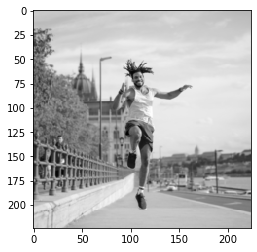

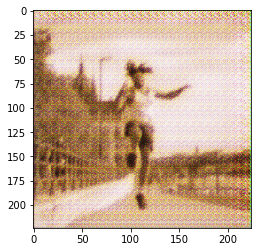

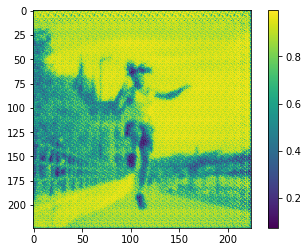

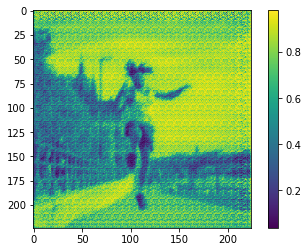

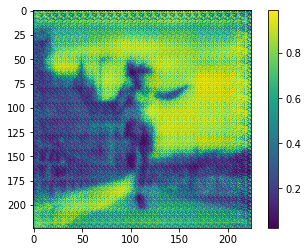

<Figure size 432x288 with 0 Axes>

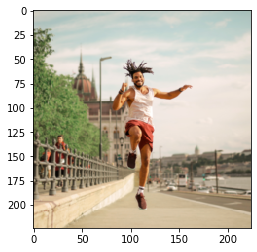

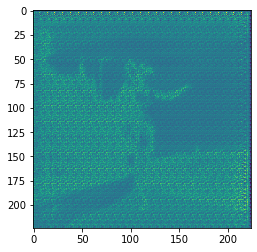

In [31]:
cpuModel = model.cpu()
out = model.generate(ex[1])
plt.figure()
plt.imshow(TenToPic(ex[1][0,:,:,:]))
plt.figure()
plt.imshow(TenToPic((out[0,:,:,:])))
plt.figure()
plt.imshow(out.detach().numpy()[0,0,:,:])
plt.colorbar()
plt.figure()
plt.imshow(out.detach().numpy()[0,1,:,:])
plt.colorbar()
plt.figure()
plt.imshow(out.detach().numpy()[0,2,:,:])
plt.colorbar()
plt.figure()
model.cuda()
temp = 1
plt.figure()
plt.imshow(TenToPic(ex[0][0,:,:,:]))
import pytorch_ssim
print("-----------")
print(pytorch_ssim.ssim(out[:,:,:,:], ex[0][:,:,:,:]))
print(pytorch_ssim.ssim(ex[0][:,:,:,:], ex[0][:,:,:,:]))

diff = out[0,0,:,:] - out[0,1,:,:]
plt.figure()
plt.imshow(diff[:,:].detach().numpy())